In [1]:
from utils.data_cleaning import *
from utils.data_preprocess import *
from utils.evaluate import evaluate_model
from utils.cf_utils import *
from utils.models import *
from utils.big_data_helper import *
import polars as pl

from utils.maps_creater import *


import faiss
from tqdm import tqdm
from sklearn.pipeline import Pipeline


/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### DataLoding

In [2]:
data = pl.scan_parquet("data/multi_event.parquet")

In [3]:
import polars as pl

estimate_parquet_ram_usage("data/multi_event.parquet")


📁 Файл: data/multi_event.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.19 MB
🔹 Всего строк в файле: 47,790,449

📐 Примерная оценка объёма данных в памяти: 0.90 GB


### Train/test split

Для начала разделим данные на обучающую и тестовую выборки. Деление выполняется по временному признаку, поскольку мы работаем с последовательностями действий пользователей.

Чтобы избежать data leakage — ситуации, когда признаки, рассчитанные на исторических данных, могут «заглядывать» в будущее — вводится временной зазор (gap) между обучающей и тестовой частями.

В оригинальной статье https://www.arxiv.org/pdf/2505.22238  используется соотношение 300 дней обучения, 30 минут gap, 1 день теста.

В моих экспериментах наилучшие результаты получились при конфигурации: 80 дней обучения, 30 минут gap, 20 дней теста.

Чтобы приблизиться к условиям статьи, я планирую снижать размер тестовой выборки, сохраняя возможность варьировать объём обучающей части как гиперпараметр модели. Такой подход позволяет гибко контролировать баланс между длиной обучающего периода и реалистичностью оценки качества.

In [4]:
train_lf, test_lf = train_test_split(data, 1, gap_size = 30)
train_lf.sink_parquet("data/work/train_df.parquet")
test_lf.sink_parquet("data/work/test_df.parquet")

In [5]:
estimate_parquet_ram_usage("data/work/train_df.parquet")
estimate_parquet_ram_usage("data/work/test_df.parquet")


📁 Файл: data/work/train_df.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.19 MB
🔹 Всего строк в файле: 47,550,037

📐 Примерная оценка объёма данных в памяти: 0.90 GB

📁 Файл: data/work/test_df.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.19 MB
🔹 Всего строк в файле: 238,398

📐 Примерная оценка объёма данных в памяти: 0.00 GB


### Очиска и кодирование данных 
Применим необходимую предобработку для очистки и подготовки данных. Подробные рассуждения о шагах и мотивации предобработки приведены в блокноте multi_event_preprocessing.
Все функции вынесены в отдельный модуль, что делает код более читаемым, модульным и удобным для повторного использования.

Кодируем uid и item_id в числовые индексы, чтобы модели и алгоритмы могли с ними работать.

Строковые ID нельзя напрямую подать в матрицу взаимодействий или Embedding-слой, поэтому мы переводим их в диапазон 0..N.
Это нужно для эффективности (память, скорость), совместимости с моделями (Matrix Factorization, Embeddings) и стабильного маппинга между train и test.

In [6]:
train_lf = pl.scan_parquet("data/work/train_df.parquet")
test_lf = pl.scan_parquet("data/work/test_df.parquet")

In [7]:
# создаём словари индексов
user_map, item_map = build_id_maps(train_lf)

# мапим train/test
train_encoded_lf = map_with_id_maps(train_lf, user_map, item_map)
test_encoded_lf  = map_with_id_maps(test_lf,  user_map, item_map)

train_encoded_lf.sink_parquet("data/work/train_encoded_lf.parquet")
test_encoded_lf.sink_parquet("data/work/test_encoded_lf.parquet")

#### Сохраняем мар-ы для повторного кодирования

In [8]:
import json

with open("data/item_map.json", "w", encoding="utf-8") as f:
    json.dump(item_map, f, ensure_ascii=False, indent=2)

with open("data/user_map.json", "w", encoding="utf-8") as f:
    json.dump(user_map, f, ensure_ascii=False, indent=2)

In [9]:
apply_function_by_batch("data/work/train_encoded_lf.parquet", 
                         "data/work/train_df_listen.parquet", 
                         get_listen_data, 
                         "timestamp", 
                         batch_size = 10_000_000)

apply_function_by_batch("data/work/test_encoded_lf.parquet", 
                         "data/work/test_df_listen.parquet", 
                         get_listen_data , 
                         "timestamp", 
                         batch_size = 10_000_000)

apply_function_by_batch("data/work/train_encoded_lf.parquet", 
                         "data/work/train_df_likes.parquet", 
                         get_not_listen_data, 
                         "timestamp", 
                         batch_size = 10_000_000)

apply_function_by_batch("data/work/test_encoded_lf.parquet", 
                         "data/work/test_df_likes.parquet", 
                         get_not_listen_data , 
                         "timestamp", 
                         batch_size = 10_000_000)

In [10]:
# Из трейна remove_duplicates_by_timestamps
apply_function_by_batch("data/work/train_df_listen.parquet", 
                         "data/work/train_df_listen_1.parquet", 
                         remove_duplicates_by_timestamps , 
                         "timestamp", 
                         batch_size = 10_000_000)

# Из трейна filter_rare_items
apply_function_by_batch("data/work/train_df_listen_1.parquet", 
                         "data/work/train_df_listen_2.parquet", 
                         filter_rare_items , 
                         "item_id", 
                         batch_size = 10_000_000)

# Из трейна filter_rare_users
apply_function_by_batch("data/work/train_df_listen_2.parquet", 
                         "data/work/train_df_listen_3.parquet", 
                         filter_rare_users , 
                         "uid", 
                         batch_size = 10_000_000)

# Из трейна cut_track_len
apply_function_by_batch("data/work/train_df_listen_3.parquet", 
                         "data/work/train_df_listen_4.parquet", 
                         cut_track_len , 
                         "timestamp", 
                         batch_size = 10_000_000)

In [11]:
# Из трейна convert_reaction
apply_function_by_batch("data/work/train_df_likes.parquet", 
                         "data/work/train_df_likes_1.parquet", 
                         convert_reaction , 
                         "uid", 
                         batch_size = 10_000_000)

# Из трейна rename_events
apply_function_by_batch("data/work/train_df_likes_1.parquet", 
                         "data/work/train_df_likes_2.parquet", 
                         rename_events , 
                         "timestamp", 
                         batch_size = 10_000_000)

In [12]:
# Из теста convert_reaction
apply_function_by_batch("data/work/test_df_likes.parquet", 
                         "data/work/test_df_likes_1.parquet", 
                         convert_reaction , 
                         "uid", 
                         batch_size = 10_000_000)

# Из теста rename_events
apply_function_by_batch("data/work/test_df_likes_1.parquet", 
                         "data/work/test_df_likes_2.parquet", 
                         rename_events , 
                         "timestamp", 
                         batch_size = 10_000_000)

In [13]:
concat_files("data/work/test_df_listen.parquet", "data/work/test_df_likes_2.parquet", "data/work/test_df_preprocessed.parquet")

concat_files("data/work/train_df_listen_4.parquet", "data/work/train_df_likes_2.parquet", "data/work/train_df_preprocessed.parquet")


In [14]:
estimate_parquet_ram_usage("data/work/train_df_preprocessed.parquet")
estimate_parquet_ram_usage("data/work/test_df_preprocessed.parquet")


📁 Файл: data/work/train_df_preprocessed.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.27 MB
🔹 Всего строк в файле: 31,907,005

📐 Примерная оценка объёма данных в памяти: 0.83 GB

📁 Файл: data/work/test_df_preprocessed.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.27 MB
🔹 Всего строк в файле: 237,786

📐 Примерная оценка объёма данных в памяти: 0.01 GB


#### Map для "уже послушанных песен пользователя"

Так как цель предсказывать что-то новое, что нужно фильтровать песни которые пользователь уже видел из рекомендаций, а так же не учитывать их при тестировании. При тестировании список прослушанных песен пользователя должен фильтровался от уже прослушанных, так как система не предсказывает такие песни и нет смысла учитывать их при тестировании. Пользователи которые не слушают новые песни не включаются в оценки (модель не может угадывать то, чего не было). Для учета таких случаев будет введена отдельная метрика, показывающая вовлеченность пользователей в рекомендательную систему.

In [15]:
# Береме данные до препроцессинка (но закодированные)
history =  pl.scan_parquet("data/work/train_encoded_lf.parquet")

test_df = pl.scan_parquet("data/work/test_df_preprocessed.parquet")
test_users_items_df = remove_listened_data(test_df)

test_users_items_df.sink_parquet("data/work/test_df_preprocessed_for_eval.parquet")


In [2]:
train_df = pl.scan_parquet("data/work/train_df_preprocessed.parquet")
test_df  = pl.scan_parquet("data/work/test_df_preprocessed_for_eval.parquet") 
history =  pl.scan_parquet("data/work/train_encoded_lf.parquet")
users_history = build_users_history(history, last_days=30)

# Models

## Baseline

#### Глобальные тренды

Самый простой базовый подход — взять топ-10 самых популярных треков. При этом возможны два варианта отбора:

* по количеству лайков,
* по количеству прослушиваний.

Реализованы обе версии, однако в качестве базовой модели (baseline) выбран именно топ-10 самых залайканных треков среди всех пользователей. Лайки считаются более надёжным сигналом предпочтений, чем прослушивания. (Для чистоты эксперимента был протестирован и вариант с прослушиваниями — его точность оказалась ниже.)



Поскольку тренды и популярные песни сменяются очень быстро, временное окно, в котором мы определяем тренд, также должно быть коротким. (*PS нужно оптимизировать выбор автоматически*)

In [17]:
model = MostPop_by_likes()
model.fit(train_df)
evaluate_model(model, users_history, test_df)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 23817.93it/s]

Mean Recall@10: 0.015399978144962747
Mean NDCG@10: 0.026082193739347368


In [17]:
model = MostPop_by_listen()
model.fit(train_df)

evaluate_model(model, users_history, test_df)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 50589.47it/s]

Mean Recall@10: 0.01248428881344854
Mean NDCG@10: 0.02367576645027094


#### Новинки последних дней

Похоже на модель популярных песен, но берет только новые песни. В топ прослушаных могут попадать к примеру песня Шуфутинского 3го сентября 

In [5]:
model = NewItemsLastNDays()
model.fit(train_df)

evaluate_model(model, users_history, test_df)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 51998.04it/s]

Mean Recall@10: 0.006657907090237797
Mean NDCG@10: 0.015225396394740779


#### Последнее прослушанное

Скорее всего пользователь в ближайщем времени послушает то, что слушал некоторое время назад. Такое предсказние дает большой процент точности, но не совсем то что нужно для рекомендательной системы, у которой цель посоветовать что-то новое и не из последний песен плейлиста. Такие песни можно будет исключать в будущем 

In [6]:
test_df  = pl.scan_parquet("data/work/test_df_preprocessed_for_eval.parquet") 
train_df = pl.scan_parquet("data/work/train_df_preprocessed.parquet")

model = LastListenRecommender()


hour = 24
decay = 0.9
tau = 0.0 if hour == 0 else decay ** (1 / 24 / 60 / 60 / (hour / 24))

df_tau = add_exponential_decay(train_df, tau)

model.fit(df_tau)

evaluate_model(model, users_history, test_df, 50) # 50 потому что в планах фильтровать последние 50 прослушанных 

100%|████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:18<00:00, 267.68it/s]

Mean Recall@50: 0.23084021504394486
Mean NDCG@50: 0.20862530927606193


## Collaborative filtering

### ALS

AlternatingLeastSquares (ALS) — это модель матричной факторизации для неявных откликов (implicit feedback).
Она раскладывает матрицу взаимодействий пользователей и объектов на две матрицы эмбеддингов — пользователей и айтемов — так, чтобы их скалярное произведение предсказывало интерес.
Обучается поочерёдным решением задач наименьших квадратов: сначала фиксирует айтемы и обновляет пользователей, потом наоборот.


В одной итерации ALS поочерёдно пересчитывает вектора пользователей и айтемов.
Сначала, при фиксированных айтемах, решаются задачи наименьших квадратов для всех пользователей;
потом, при фиксированных пользователях — для всех айтемов.
Это повторяется несколько итераций, пока модель не сойдётся.

Для обучения ALS требуется подготовить данные в формате матрицы взаимодействий, где каждая ячейка отражает степень интереса пользователя к объекту. Поскольку в нашем случае используются implicit-сигналы, нам необходимо преобразовать исходные события (прослушивание, лайк, дизлайк) в числовые веса.

На этапе подготовки данных мы подсчитываем, сколько раз пользователь прослушал каждый трек, а также приводим реакции к бинарному виду:
в результирующем датафрейме поле like получает значение 1,
аналогично dislike — значение 1.

В отдельном модуле реализована функция объединения данных, которая формирует итоговый датафрейм с колонками:

* признак лайка (like = 1)
* признак дизлайка (dislike = 1)
* количество прослушиваний каждой пары пользователь–трек

In [14]:

train_df_conf = merge_data_by_count(train_df)
train_df_conf = calculate_conf(train_df_conf)

(
    train_df_conf
    .collect()  # выполняем план, получаем обычный DataFrame
    .write_parquet("data/work/train_df_conf.parquet")
)

In [15]:
estimate_parquet_ram_usage("data/work/train_df_conf.parquet")


📁 Файл: data/work/train_df_conf.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 0.36 MB
🔹 Всего строк в файле: 7,299,039

📐 Примерная оценка объёма данных в памяти: 0.26 GB


Для ALS необходима разреженная матрица вида:

(user_id, item_id) → weight


где weight — это итоговая сила взаимодействия (прослушивания + реакции).
В модуле реализована функция, которая на основе сформированного датафрейма строит такую матрицу через coo_matrix и возвращает её в подходящем для модели формате.

In [16]:
train_df_conf = pl.scan_parquet("data/work/train_df_conf.parquet")

# train_df_conf = train_df_conf.with_columns(
#     (pl.col("conf") != 0).cast(pl.Int8).alias("conf")
# )

model = ALS()
model.fit(train_df_conf)



100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.12s/it, loss=0.00177]


In [17]:
evaluate_model(model, users_history, test_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 4827/4827 [01:56<00:00, 41.46it/s]

Mean Recall@10: 0.019113867762854484
Mean NDCG@10: 0.04434291029592605


Метод ALS работает только с пользователями и объектами, которые присутствовали в обучающей выборке. Если в тесте встречается пользователь, которого модель ранее не видела, для него невозможно построить профиль в факторизационном пространстве.

В такой ситуации ALS не способен выдать рекомендации — в классе ALS такая логика приводит к возврату пустого списка.

Поэтому при использовании ALS важно учитывать, что:

* рекомендации гарантированно работают только для пользователей из train,
* все новые или ранее невстречавшиеся пользователи будут давать «пустой» результат.

Это естественное ограничение моделей матричной факторизации, основанных на implicit-feedback данных.

### BM25Rec

In [75]:
model = BM25Rec()
model.fit(train_df_conf)
evaluate_model(model, users_history, test_df)


### ItemKNN

In [209]:
model = ItemKNN()
model.fit(train_df)
evaluate_model(model, users_history, test_df, k=10)

100%|█████████████████████████████████████████████████████████████████████████████████| 4827/4827 [01:46<00:00, 45.44it/s]

Mean Recall@10: 0.0431855077752173
Mean NDCG@10: 0.08053783579665744


 В памяти все хранить очень тяжело, но по математическим расчетам это тоже самое, поэтому используем
 Конечно тоже не быстро но лучше чем было

### BPR

In [210]:
train_df_conf = pl.scan_parquet("data/work/train_df_conf.parquet")

train_df_conf = train_df_conf.with_columns(
    (pl.col("conf") != 0).cast(pl.Int8).alias("conf")
)

model = BPR()
model.fit(train_df_conf)

evaluate_model(model, users_history, test_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 4827/4827 [01:57<00:00, 41.08it/s]

Mean Recall@10: 0.014311525458997233
Mean NDCG@10: 0.030514844986110252


## Graph-based recommendation

In [26]:
import json 
train_df = pl.scan_parquet("data/work/train_df_preprocessed.parquet")


df_merged = merge_data_by_count(train_df)


with open("data/item_map.json", "r", encoding="utf-8") as f:
    item_map = json.load(f)

item_map = {int(k): v for k, v in item_map.items()}

items_meta = (
    pl.scan_parquet("data/items_meta.parquet")
    .with_columns(
        pl.col("item_id").replace(item_map)
    )
    .unique(subset=["item_id"])
    .drop_nulls()
)

lf_user_track = df_merged.join(
    items_meta.select(["item_id", "artist_id", "album_id"]),
    on="item_id",
    how="left",
)

In [60]:
model = RandomWalkWithRestart()
model.fit(lf_user_track)
# test_users_items_df.filter(pl.col("uid") < 500)
evaluate_model(model, users_history, test_df, k=10)

100%|█████████████████████████████████████████████████████████████████████████████████| 4827/4827 [03:24<00:00, 23.63it/s]

Mean Recall@10: 0.05633607971711287
Mean NDCG@10: 0.10609058390022198


## Content_based 

Content-Based Filtering — это метод рекомендаций, который подбирает объекты, похожие на те, что пользователь уже оценил, используя их содержательные признаки (жанры, embedding-и, особенности контента). Его сильная сторона в том, что он не зависит от других пользователей, хорошо работает для новых объектов (нет cold-start для items) и даёт легко объяснимые рекомендации. Однако у подхода есть ограничения: качество сильно зависит от самих признаков, модель не умеет учитывать тренды или контекст поведения, а рекомендации могут быть слишком однообразными и «сужать» вкусы пользователя.


#### embeddongs 

Методы точного поиска ближайших соседей (kNN) требуют вычислять расстояние между вектором-запросом и каждым объектом в базе, поэтому их сложность линейная 
𝑂
(
𝑁
)
O(N), и на больших наборах данных с десятками или сотнями тысяч элементов они становятся крайне медленными: нужно выполнить миллионы скалярных произведений при каждом запросе. По этой причине в рекомендациях и поиске похожих объектов чаще используют ANN (Approximate Nearest Neighbors) — алгоритмы, которые строят специальный индекс (HNSW, Annoy, Faiss и др.) и ищут ближайших соседей не полностью перебирая весь набор, а умно обходя лишь небольшую часть точек. В результате скорость поиска ускоряется в десятки–сотни раз при минимальной потере качества, что делает ANN практически стандартом для больших эмбеддингов.

Предсказания по эмбедингам
Суть найти максимальное похожее на то что уже слышуал пользователь. При этом берутся именно органические прослушивания, то что человек выбрал сам
ПРосулшивания берутся свержие (используеются экспоненциальное затухание). 
Профиль пользователя строится из нескольких векторов  - берутся последний прослушанные, по ним проводится кластеризация, и берутся центры кластеров. Делается это для того чтобы не брать среднее между разными жанрами ()
Для кластеризации используется сферчикский kmean shift. Обчный kmean требует количество кластеров, а это сложно угадать сколько разных жарнов челвоек слушал послднее время. DBSCAN очень хорошо отрабатывает на сложных формах, но в данном случае нам нужны именно плотные сгустки векторов. Если Выбирать сложные формы (это будет полезно но для выделение глобальных жанров) , то можем получить точку в другом кластере совершенно.}
Так же используется джиттер чтобы добавить некоторой рандомности

В данном случае модель с эмедингами будет нацелена на предсказание совершенно новых треков, очен похожих, но которые человек еще не слышал вообще и в его истории просшуливаний нет таких треков.

In [11]:
# import json
# from utils.embeddings import *

# with open("data/item_map.json", "r", encoding="utf-8") as f:
#     item_map = json.load(f)

# item_map = {int(k): v for k, v in item_map.items()}

# index, all_item_ids = create_index("data/filtered_embeddings.parquet", item_map)



added up to offset=100000, total indexed=99757
added up to offset=150000, total indexed=149640
added up to offset=200000, total indexed=199532
added up to offset=250000, total indexed=249413
added up to offset=300000, total indexed=299301
added up to offset=350000, total indexed=349176
added up to offset=400000, total indexed=399045
added up to offset=450000, total indexed=448925
added up to offset=500000, total indexed=498808
added up to offset=550000, total indexed=548684
added up to offset=600000, total indexed=598557
added up to offset=650000, total indexed=648439
added up to offset=700000, total indexed=698323
added up to offset=750000, total indexed=748229
added up to offset=800000, total indexed=798118
added up to offset=850000, total indexed=845905


In [136]:
model = CBF_by_embeding_kmean()

model.fit(train_df, index, all_item_ids)

evaluate_model(model, users_history, test_df.filter(pl.col("uid") < 500) , 10)

100%|███████████████████████████████████████████████████████████████████████████████████| 237/237 [00:07<00:00, 30.34it/s]

Mean Recall@10: 0.0056175667305677175
Mean NDCG@10: 0.007867740151438138


In [60]:
real = test_df.filter(pl.col("uid") == 39).collect()["items"].to_list()[0]
pred = model.recommend(39)[0]

Заметки грустного ML-шика: После первой попытки точность была крайне маленькой

## Ранжирование

Ранжирование (Learning to Rank) — это задача, в которой модель не просто предсказывает значение, а упорядочивает объекты так, чтобы наиболее релевантные оказались выше в списке. Такой подход используется в поиске, рекомендациях и подборе контента — везде, где важна правильная сортировка результатов.

CatBoost хорошо подходит для ранжирования, потому что:

* поддерживает современные алгоритмы LTR (YetiRank, PairLogit и др.);
* отлично работает с категориальными признаками без дополнительной обработки;
* показывает высокую устойчивость и качество «из коробки»;
* легко использовать — достаточно передать группы (group_id).

Поэтому CatBoostRanker — удобная и мощная модель для построения систем рекомендаций и поиска.

### Гибридная модель

Объединием все полученные модели в одну гибридную. Каждая будет выдвать свой топ предсказаний ( но будем брать не 10 а больше). Затем полученные результаты будут уходить на вход модели ранжирования

топ 10 предсказания как правильно все разные - важно отобрать верно нужное

In [38]:
tmp = all_data(train_df)

item_id = 308504
uid = 5288
"median_daily_plays", "days_since_last_play", "user_total_plays", "user_unique_tracks", "track_length_seconds"



uid,item_id,listen_count,played_ratio_max,dislike_flag,like_flag,conf,user_total_plays,user_active_days,user_unique_tracks,median_daily_plays,mean_plays_per_day,unique_tracks_share,days_since_last_play,item_total_plays,item_unique_users,track_length_seconds
i64,i64,u32,u16,i32,i32,f64,u32,u32,u32,f64,f64,f64,f64,u32,u32,u32
5288,308504,2,99,0,0,1.091923,2279,82,842,18.5,27.792683,0.36946,0.230324,165,59,190
2974,632949,4,100,0,0,1.609438,9584,258,3208,30.0,37.147287,0.334725,0.2261,109,46,220
7494,869004,2,59,0,0,0.779325,5500,198,1767,22.0,27.777778,0.321273,1.233449,14,10,210
8939,137792,2,100,0,0,1.098612,3822,230,1339,12.0,16.617391,0.35034,0.439699,313,123,205
6600,233921,3,100,0,0,1.386294,8640,230,2409,35.5,37.565217,0.278819,0.225984,481,147,100
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3450,487414,1,100,0,0,0.693147,4048,137,1866,25.0,29.547445,0.460968,2.246528,75,31,150
6011,374480,4,100,0,0,1.609438,7194,244,2018,27.5,29.483607,0.280512,0.082407,816,293,285
3368,139811,22,100,0,0,3.135494,10985,209,2040,47.0,52.559809,0.185708,0.110822,515,141,175


In [77]:
from catboost import CatBoostRanker
from utils.evaluate import filtering_listened_items


def calculate_conf_hyp(lf: pl.LazyFrame) -> pl.LazyFrame:
    lf = lf.filter(pl.col("played_ratio_max")>50)    
    return lf.with_columns(
        (
            20.0 * pl.col("like_flag").cast(pl.Float64)
            - 10.0 * pl.col("dislike_flag").cast(pl.Float64)
             +(
                pl.col("listen_count").cast(pl.Float64)
                * (pl.col("played_ratio_max").cast(pl.Float64) / 100.0)
            ).log1p()
        ).alias("conf")
    )



def all_data(train_df):
    train_df_conf_hyp = merge_data_by_count(train_df)
    train_df_conf_hyp = calculate_conf_hyp(train_df_conf_hyp)

    df = train_df_conf_hyp.join(user_music_stats(train_df), on='uid', how='left')
    df = df.join(build_item_stats(train_df), on='item_id', how='left')

    return df



def prepere_dataset(train_df):
    train_df_conf_hyp = merge_data_by_count(train_df)
    train_df_conf_hyp = calculate_conf_hyp(train_df_conf_hyp)

    df = train_df_conf_hyp.join(user_music_stats(train_df), on='uid', how='left')
    df = df.join(build_item_stats(train_df), on='item_id', how='left')

    tdf = df.filter(pl.col("uid") <500)
    tdf = tdf.sort(by=['uid'])
    
    X_train = tdf.select(["median_daily_plays", "days_since_last_play", "user_total_plays", "user_unique_tracks", "track_length_seconds"]).collect().to_pandas()
    y_train = tdf.select(["conf"]).collect().to_pandas()
    group_id = tdf.select(["uid"]).collect().to_pandas()

    return X_train, y_train , group_id


    

class HybridModel:
    def __init__(self):
        self.trend_model = MostPop_by_likes()
        self.new_items_model = NewItemsLastNDays()
        self.als = ALS()
        self.item_knn = ItemKNN()
        
        self.N = 10
        self.limit = 10
        self.test = False
        self.use_history = False

    
    def fit(self, train_df, train_df_conf_als):
        print("Prepere history")

        history = (
            train_df
            .filter(pl.col("event_type") == "listen")
            # .filter(pl.col("is_organic") == 1)
            .select(["uid", "item_id", "timestamp"])
            .group_by(["uid", "item_id"])
            .agg(pl.col("timestamp").max().alias("last_timestamp"))
            .filter(pl.col("last_timestamp") >(60*60*24*300 - 60*60*24*7))
            .group_by("uid")
            .agg(pl.col("item_id"))      # без .list()
            .collect()
            
        )
        
        self.uid_to_items = dict(
            zip(
                history["uid"].to_list(),
                history["item_id"].to_list(),   # это уже списки item_id
            )
        )
                        
        print("Train recomended models")
        print("trend_model")
        self.trend_model.fit(train_df)
        self.new_items_model.fit(train_df) 

        train_df_conf_als = train_df_conf_als.with_columns(
                (pl.col("conf") != 0).cast(pl.Int8).alias("conf")
            )

        self.mean_user = mean_daily_plays(train_df, group="uid")
        self.days_since_last_play = days_since_last_play(train_df)
        self.user_stats = get_user_stats(train_df).collect()
        self.item_stats = build_item_stats(train_df).collect()
        # self.als.fit(train_df_conf_als)
        # self.item_knn.fit(train_df)
        
        self.all_data = all_data(train_df)

        
        
        print("Prepere data for rancin model")
        self.X_train, self.y_train , self.group_id = prepere_dataset(train_df)
        
        print("Train rancin model")
        
        
        self.hybrid_model = CatBoostRanker(
            iterations=3,
            learning_rate=0.05,
            depth=6,
            loss_function="YetiRank",
            verbose=50,
        )
        
    def fit_ranker(self):
        self.hybrid_model.fit(
            self.X_train,
            self.y_train,
            group_id=self.group_id,
        )
    
    def gather_candidates(self, uid):

        candidates = set()
        
        
        rec, weights = self.trend_model.recommend(uid)
        rec, weights = rec[:self.limit], weights[:self.limit]

        candidates = candidates | set(rec)
        
        rec, weights = self.new_items_model.recommend(uid)
        rec, weights = rec[:self.limit], weights[:self.limit]
    
        candidates = candidates | set(rec)
                        
        return candidates

    
    def make_features(self, user_id, candidates):
        rows = []
        user_features = get_user_features( self.user_stats, user_id)
        
        for item_id in candidates:

            item_features = get_item_features(self.item_stats, item_id)
    
            row = {
               
                "median_daily_plays":   self.mean_user.get(user_id, 0),
                "days_since_last_play": self.days_since_last_play.get(user_id, 0),
                "user_total_plays": user_features["user_total_plays"],
                "user_unique_tracks": user_features["user_unique_tracks"],
                "track_length_seconds": item_features["track_length_seconds"],
            }
            rows.append(row)
        
        return rows


    def recommend(self, uid):
        candidates = self.gather_candidates(uid)
        if not candidates:
            return []
    
        # если gather_candidates возвращает dict {item_id: ...}
        candidates = list(candidates)
        
        rows = self.make_features(uid, candidates)
        if not rows:
            return []
    
        df = pd.DataFrame(rows)
        df["item_id"] = candidates
        
        if df.empty:
            return [], []
    
        # В МОДЕЛЬ НЕ ПОДАЁМ item_id
        X = df.drop(columns=["item_id"])
    
        scores = self.hybrid_model.predict(X)
        df["score"] = scores
    
        # item_id уже есть в df из make_features, НЕ нужно df["item_id"] = candidates
        df_sorted = df.sort_values("score", ascending=False)
    
        return df_sorted["item_id"].tolist(), df_sorted["score"].tolist()



In [78]:
train_df_conf = pl.scan_parquet("data/work/train_df_conf.parquet")
train_df = pl.scan_parquet("data/work/train_df_preprocessed.parquet")

hybrid = HybridModel()

hybrid.fit(train_df, train_df_conf)
 


Prepere history
Train recomended models
trend_model
Prepere data for rancin model
Train rancin model


In [107]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRanker, Pool
import pandas as pd
import numpy as np

# X_train, X_test, y_train, y_test, group_train, group_test
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    hybrid.X_train,
    hybrid.y_train,
    hybrid.group_id,
    test_size=0.2,
    random_state=42
)

# ---- 1. Собираем train в один DataFrame и сортируем по group_id ----
train_df = X_train.copy()
train_df["label"] = y_train
train_df["group_id"] = group_train

train_df = train_df.sort_values("group_id").reset_index(drop=True)

X_train_sorted = train_df.drop(columns=["label", "group_id"])
y_train_sorted = train_df["label"]
group_train_sorted = train_df["group_id"]

# ---- 2. То же самое для test ----
test_df = X_test.copy()
test_df["label"] = y_test
test_df["group_id"] = group_test

test_df = test_df.sort_values("group_id").reset_index(drop=True)

X_test_sorted = test_df.drop(columns=["label", "group_id"])
y_test_sorted = test_df["label"]
group_test_sorted = test_df["group_id"]

# ---- 3. Создаём Pools ----
train_pool = Pool(
    data=X_train_sorted,
    label=y_train_sorted,
    group_id=group_train_sorted,
)

test_pool = Pool(
    data=X_test_sorted,
    label=y_test_sorted,
    group_id=group_test_sorted,
)

# ---- 4. Обучаем CatBoostRanker ----
hybrid.hybrid_model = CatBoostRanker(
    iterations=30,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
)

hybrid.hybrid_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=True
)

0:	test: 0.5534141	best: 0.5534141 (0)	total: 879ms	remaining: 25.5s
1:	test: 0.5874705	best: 0.5874705 (1)	total: 1.47s	remaining: 20.6s
2:	test: 0.5913038	best: 0.5913038 (2)	total: 2.03s	remaining: 18.3s
3:	test: 0.6406715	best: 0.6406715 (3)	total: 2.58s	remaining: 16.8s
4:	test: 0.6467409	best: 0.6467409 (4)	total: 3.12s	remaining: 15.6s
5:	test: 0.6531380	best: 0.6531380 (5)	total: 3.68s	remaining: 14.7s
6:	test: 0.6614239	best: 0.6614239 (6)	total: 4.32s	remaining: 14.2s
7:	test: 0.6608233	best: 0.6614239 (6)	total: 4.91s	remaining: 13.5s
8:	test: 0.6624197	best: 0.6624197 (8)	total: 5.55s	remaining: 12.9s
9:	test: 0.6675739	best: 0.6675739 (9)	total: 6.11s	remaining: 12.2s
10:	test: 0.6689891	best: 0.6689891 (10)	total: 6.71s	remaining: 11.6s
11:	test: 0.6708132	best: 0.6708132 (11)	total: 7.29s	remaining: 10.9s
12:	test: 0.6716870	best: 0.6716870 (12)	total: 7.84s	remaining: 10.3s
13:	test: 0.6728530	best: 0.6728530 (13)	total: 8.4s	remaining: 9.6s
14:	test: 0.6727894	best: 0.

In [89]:
# hybrid.recommend(1)

In [108]:
hybrid.limit = 20
val_df  = pl.scan_parquet("data/work/test_df_preprocessed_for_eval.parquet") 

evaluate_model(hybrid, users_history, val_df.filter(pl.col("uid") < 500) , 10)

10


100%|███████████████████████████████████████████████████████████████████████████████████| 237/237 [00:08<00:00, 27.60it/s]

237 237
Mean Recall@10: 0.005724975811011299
Mean NDCG@10: 0.005040268076215057


### Feature enginiring

#### Фичи по объему 

In [22]:
import polars as pl


def mean_daily_plays(df: pl.LazyFrame | pl.DataFrame, group: str | None = None) -> pl.DataFrame:
    """
    Считает среднее количество прослушиваний в день.
    """

    # LazyFrame, если нужно
    ldf = df.lazy() if isinstance(df, pl.DataFrame) else df

    # нормализуем дату
    ldf = ldf.with_columns(
        pl.from_epoch(pl.col("timestamp"), time_unit="s").dt.date().alias("date")
    )

    out = (
        ldf.group_by([group, "date"])
           .agg(pl.len().alias("plays_per_day"))
           .group_by(group)
           .agg(pl.col("plays_per_day").median().alias("mean_daily_plays"))
           .collect()
    )
    return {
            row["uid"]: row["mean_daily_plays"]
            for row in out.iter_rows(named=True)
        }


def days_since_last_play(df: pl.LazyFrame | pl.DataFrame) -> pl.DataFrame:
    """
    Возвращает таблицу:
    uid | days_since_last_interaction
    timestamp — UNIX time в секундах
    """
    ldf = df.lazy() if isinstance(df, pl.DataFrame) else df

    max_ts = ldf.select(pl.col("timestamp").max().alias("max_ts")).collect()["max_ts"][0]

    last_ts = (
        ldf.group_by("uid")
           .agg(pl.col("timestamp").max().alias("last_timestamp"))
           .collect()
    )

    result = (
        last_ts.with_columns([
            ((pl.lit(max_ts) - pl.col("last_timestamp")) / (60 * 60 * 24))
            .alias("days_since_last_play")
        ])
    )

    return {
            row["uid"]: row["days_since_last_play"]
            for row in result.iter_rows(named=True)
        }



def get_user_stats(df):
    return (
        df.lazy()
          .with_columns(pl.from_epoch("timestamp", time_unit="s").dt.date().alias("date"))
          .group_by("uid")
          .agg([
              pl.len().alias("user_total_plays"),
              pl.col("date").n_unique().alias("user_active_days"),
              pl.col("item_id").n_unique().alias("user_unique_tracks"),
          ])
          .with_columns([
              (pl.col("user_total_plays") / pl.col("user_active_days")).alias("user_mean_plays_per_day"),
              (pl.col("user_unique_tracks") / pl.col("user_total_plays")).alias("user_unique_tracks_share")
          ])
    )

def get_user_features(user_stats: pl.DataFrame, uid: int) -> dict:
    row = user_stats.filter(pl.col("uid") == uid)

    if row.height == 0:      # <--- пользователь не найден
        return {
            "user_total_plays": 0,
            "user_active_days": 0,
            "user_unique_tracks": 0,
            "user_mean_plays_per_day": 0.0,
            "user_unique_tracks_share": 0.0,
        }

    return row.select(pl.exclude("uid")).to_dicts()[0]


def user_music_stats(df: pl.LazyFrame | pl.DataFrame, group: str | None = None) -> pl.DataFrame:
    """
    Рассчитывает для каждого пользователя:
    - общее количество прослушиваний
    - количество активных дней
    - количество уникальных треков
    - среднее количество прослушиваний в день (медианное по дням)
    - долю уникальных треков от всех прослушиваний
    - дни с момента последнего прослушивания
    """

    ldf = df.lazy() if isinstance(df, pl.DataFrame) else df

    # Нормализуем дату
    ldf = ldf.with_columns(
        pl.from_epoch(pl.col("timestamp"), time_unit="s").dt.date().alias("date")
    )

    # Последний таймстамп из всего датасета
    max_ts = ldf.select(pl.col("timestamp").max().alias("max_ts")).collect()["max_ts"][0]

    # Считаем количество прослушиваний в каждый день по пользователям
    plays_per_day = (
        ldf.group_by(["uid", "date"])
           .agg(pl.len().alias("plays_per_day"))
    )

    # Среднее (медианное) количество прослушиваний в день на пользователя
    median_daily_plays = (
        plays_per_day.group_by("uid")
                     .agg(pl.col("plays_per_day").median().alias("median_daily_plays"))
    )

    # Статистика пользователя по всей истории
    user_stats = (
        ldf.group_by("uid")
           .agg([
               pl.len().alias("user_total_plays"),
               pl.col("date").n_unique().alias("user_active_days"),
               pl.col("item_id").n_unique().alias("user_unique_tracks"),
               pl.col("timestamp").max().alias("last_timestamp"),
           ])
    )

    # Рассчитываем дополнительные колонки и объединяем результаты
    result = (
        user_stats.join(median_daily_plays, on="uid")
                  .with_columns([
                      (pl.col("user_total_plays") / pl.col("user_active_days")).alias("mean_plays_per_day"),
                      (pl.col("user_unique_tracks") / pl.col("user_total_plays")).alias("unique_tracks_share"),
                      ((pl.lit(max_ts) - pl.col("last_timestamp")) / (60 * 60 * 24)).alias("days_since_last_play"),
                  ])
                  .select([
                      "uid",
                      "user_total_plays",
                      "user_active_days",
                      "user_unique_tracks",
                      "median_daily_plays",
                      "mean_plays_per_day",
                      "unique_tracks_share",
                      "days_since_last_play"
                  ])
                  
    )
    return result

def build_item_stats(df: pl.LazyFrame | pl.DataFrame) -> pl.DataFrame:
    """
    Считает фичи:
        item_total_plays   = общее количество прослушиваний трека
        item_unique_users  = число уникальных пользователей трека

    Ожидает колонки: ['uid', 'item_id']
    """

    ldf = df.lazy() if isinstance(df, pl.DataFrame) else df

    item_stats = (
        ldf.group_by("item_id")
           .agg([
               pl.len().alias("item_total_plays"),
               pl.col("uid").n_unique().alias("item_unique_users"),
               pl.col("track_length_seconds").max().alias("track_length_seconds"),
           ])
           
    )

    return item_stats

def get_item_features(item_stats: pl.DataFrame, item_id: int) -> dict:
    row = item_stats.filter(pl.col("item_id") == item_id)

    if row.height == 0:      # <--- пользователь не найден
        return {
            "item_total_plays": 0,
            "item_unique_users": 0,
            "track_length_seconds": 0,
        }

    return row.select(pl.exclude("item_id")).to_dicts()[0]





In [19]:
hybrid_model = CatBoostRanker(
    iterations=30,
    learning_rate=0.05,
    depth=6,
    loss_function="YetiRank",
    verbose=2,
)

hybrid_model.fit(
    X_train,
    y_train,
    group_id,
)

0:	total: 1.46s	remaining: 42.3s
2:	total: 3.21s	remaining: 28.9s
4:	total: 4.91s	remaining: 24.5s
6:	total: 6.55s	remaining: 21.5s
8:	total: 8.16s	remaining: 19s
10:	total: 9.82s	remaining: 17s
12:	total: 11.5s	remaining: 15s
14:	total: 13.1s	remaining: 13.1s
16:	total: 14.7s	remaining: 11.3s
18:	total: 16.4s	remaining: 9.51s
20:	total: 18.1s	remaining: 7.75s
22:	total: 19.8s	remaining: 6.02s
24:	total: 21.5s	remaining: 4.3s
26:	total: 23.2s	remaining: 2.57s
28:	total: 24.8s	remaining: 855ms
29:	total: 25.7s	remaining: 0us


In [ ]:
# Поведенческие фичи
# История прослушиваний: какие треки слушал пользователь, как часто, сколько времени провел на треке

# Лайки, дизлайки, добавления в избранное, повторные прослушивания

# Средняя длина прослушивания, частота прослушивания треков одного артиста или жанра

# Сегменты пользователей по интересам, похожие пользователи (collaborative filtering)

## Анализ ошибок 

Точность системы составляла 2.7
Были выбраны пользоваетли для которых есть пересечения из всего списка рекомендаций есть попадания.
Было обнаружено что они находятся на >10 индексах, а между ними в основном треки которые были недавно показаны уже пользователю
Был добавлен фильтр на последние показанные песни 

In [ ]:
# Посмотрим вывод нескольких моделей


In [97]:
from tqdm import tqdm
from utils.metrics import ndcg_at_k, recall_at_k
import numpy as np
import polars as pl

def filtering_listened_items(rec, weights, listened_items: set, k=None):
    filtered_rec = []
    filtered_weights = []

    for item, weight in zip(rec, weights):
        if item in listened_items:
            continue
        filtered_rec.append(item)
        filtered_weights.append(weight)
        if k is not None and len(filtered_rec) >= k:
            break

    return filtered_rec, filtered_weights
    

def evaluate_model(model, user_history, test_lf: pl.LazyFrame, k: int = 10):
    print(k)
    overall_recall = []
    overall_ndcg = []
    test_lf = test_lf.collect()
    for i in tqdm(range(len(test_lf))): 
        
        uid = test_lf[i, "uid"] 
        user_true = set(test_lf[i, "items"] )

        
        if not user_true:
            continue
        try:
            rec, weights = model.recommend(uid)
        except:
            rec, weights = [], []

        if not rec:
            continue

        recall = recall_at_k(rec, user_true, k)
        ndcg = ndcg_at_k(rec, user_true, k)

        if uid in [6339, 7905, 929]:
            print(uid, ndcg, rec[:10])
        
        overall_recall.append(recall)
        overall_ndcg.append(ndcg)
    print(len(overall_recall),len(test_lf) )
    print("Mean Recall@{}:".format(k), np.mean(overall_recall))
    print("Mean NDCG@{}:".format(k), np.mean(overall_ndcg))

In [39]:
results = {
    "MostPop": {
        929: {
            "score": 0.06943122193677727,
            "items": [679713, 368953, 492083, 587807, 77971, 584672, 661967, 272391, 673338, 221077]
        },
        7905: {
            "score": 0.0,
            "items": [679713, 368953, 492083, 587807, 77971, 584672, 661967, 272391, 673338, 221077]
        },
        6339: {
            "score": 0.3589542101716347,
            "items": [679713, 368953, 492083, 587807, 77971, 584672, 661967, 272391, 673338, 221077]
        },
    },

    "MostPop_by_listen": {
        929: {
            "score": 0.0,
            "items": [368953, 665904, 867033, 587807, 221077, 627154, 810966, 241997, 511362, 618038]
        },
        7905: {
            "score": 0.0,
            "items": [368953, 665904, 867033, 587807, 221077, 627154, 810966, 241997, 511362, 618038]
        },
        6339: {
            "score": 0.22009176629808017,
            "items": [368953, 665904, 867033, 587807, 221077, 627154, 810966, 241997, 511362, 618038]
        },
    },

    "NewItemsLastNDays": {
        929: {
            "score": 0.0,
            "items": [679713, 77971, 492083, 833867, 574324, 305144, 85378, 95745, 17549, 758397]
        },
        7905: {
            "score": 0.0,
            "items": [679713, 77971, 492083, 833867, 574324, 305144, 85378, 95745, 17549, 758397]
        },
        6339: {
            "score": 0.22009176629808017,
            "items": [679713, 77971, 492083, 833867, 574324, 305144, 85378, 95745, 17549, 758397]
        },
    },

    "LastListenRecommender": {
        929: {
            "score": 0.22009176629808017,
            "items": [351253, 589562, 801191, 546554, 837025, 476671, 665904, 587807, 55570, 386337]
        },
        7905: {
            "score": 0.36211082347570717,
            "items": [689616, 449874, 473339, 173724, 30334, 760035, 524855, 223455, 892412, 86749]
        },
        6339: {
            "score": 0.43735247915031,
            "items": [824785, 341666, 74061, 272391, 234840, 838111, 425069, 585096, 98030, 126064]
        },
    },

    "ALS": {
        929: {
            "score": 0.0,
            "items": [348693, 266016, 609187, 43405, 445383, 910003, 143673, 705928, 146600, 615306]
        },
        7905: {
            "score": 0.0,
            "items": [609187, 627154, 146600, 736229, 43405, 131632, 526016, 574331, 810966, 601953]
        },
        6339: {
            "score": 0.06362078819895171,
            "items": [402248, 842667, 333315, 568302, 269741, 791362, 25993, 626744, 587763, 723026]
        },
    },

    "ItemKNN": {
        929: {
            "score": 0.0,
            "items": [609187, 43405, 574331, 589562, 266016, 627154, 389120, 131632, 720251, 801191]
        },
        7905: {
            "score": 0.0,
            "items": [273689, 712340, 117709, 389120, 195103, 283212, 91936, 889665, 698779, 911161]
        },
        6339: {
            "score": 0.22009176629808017,
            "items": [824785, 266016, 627154, 609187, 131632, 389120, 665904, 231245, 43405, 514880]
        },
    },

    "RandomWalkWithRestart": {
        929: {
            "score": 0.0,
            "items": [4292, 386337, 445383, 864368, 929389, 280741, 817116, 439202, 436510, 644682]
        },
        7905: {
            "score": 0.08514311764162098,
            "items": [574730, 449874, 502682, 152442, 689616, 30334, 887245, 896175, 304528, 12550]
        },
        6339: {
            "score": 0.23297260855707355,
            "items": [665904, 812032, 873196, 306377, 128290, 61617, 703194, 833248, 861821, 7654]
        },
    },
}



689616, 760035, 919502
real = {
    929: [
        49480, 117709, 351253, 349176, 272391, 443975, 831161, 751383, 772200,
        724402, 648159, 644713, 534092
    ],

    7905: [
        6196, 67596, 97545, 112009, 86749, 225566, 355578, 371114, 371114,
        371114, 371114, 235307, 264794, 435380, 418343, 444097, 452208,
        419096, 445679, 820576, 797965, 852535, 584166, 582358, 584790,
        569017, 601934, 616374, 710903, 732562, 760035, 764852, 667252,
        634537, 659866, 689616, 628074, 628074, 628074, 628074, 628074,
        919502, 886213, 896685, 479918, 517109, 371114, 584166
    ],

    6339: [
        5674, 31505, 61617, 67302, 128290, 124896, 133701, 341666, 368953,
        327773, 385078, 312725, 321277, 426277, 778003, 824785, 838111,
        838111, 833248, 833248, 583461, 592555, 593426, 577188, 613770,
        704037, 727362, 762540, 715675, 723026, 752174, 645684, 650772,
        653245, 625883, 624295, 625325, 679713, 683185, 659705, 918977,
        907237, 470336, 524462, 503402
    ],
}


Идеальный мир, в котором умеем отбирать кандиндатов и имеем идеальную ранжирующую модель.
При этом есть пересечения LastListenRecommender и других моделей. В преспективе модель поможет отсеивать уже просмотренные и более релевантые выйдут в топ

In [79]:
uid  = 6339
methods = [
    "MostPop",
    "NewItemsLastNDays",
    "LastListenRecommender",
    "ALS",
    "ItemKNN",
    "RandomWalkWithRestart",
]

all_pred = [item
            for m in methods
            for item in results[m][uid]["items"]]

all_pred = list(set(all_pred) & set(real[uid]))
ndcg_at_k(all_pred, set(real[uid]), k = 10)
# len(set(all_pred) & set(real[uid])) / len(set(real[uid]))
# all_pred


0.9363792118010483

In [379]:
# model = RandomWalkWithRestart()
# model.fit(lf_user_track)

# # test_users_items_df.filter(pl.col("uid") < 500)
evaluate_model(model, users_history, test_df, k=10)  

  2%|█▉                                                                                | 116/4827 [00:32<22:17,  3.52it/s]

929 0.0 [552809.0, 728605.0, 751098.0, 196457.0, 396596.0, 712340.0, 587807.0, 35678.0, 691829.0, 316197.0]


  3%|██▋                                                                               | 161/4827 [00:43<14:43,  5.28it/s]

7905 0.20248323207250624 [747506.0, 760035.0, 276703.0, 888093.0, 441698.0, 507116.0, 260019.0, 492743.0, 334933.0, 919502.0]


100%|█████████████████████████████████████████████████████████████████████████████████| 4827/4827 [30:35<00:00,  2.63it/s]

4331 4827
Mean Recall@10: 0.03039144153770951
Mean NDCG@10: 0.05454424571972248


In [122]:
# pl.scan_parquet("data/work/test_df_preprocessed.parquet").filter(pl.col("uid") == 443975).select("items").collect().to_series().to_list()[0]  #28556
pl.scan_parquet("data/work/test_df_preprocessed.parquet").filter(pl.col("uid") == 3603).filter(pl.col("item_id")== 914910.0).collect()  #28556
# not_like = lf_user_track.filter(pl.col("played_ratio_max") < 50).filter(pl.col("uid") == 123).select(pl.col("item_id").unique()).collect().to_series().to_list()
# 689616, 760035, 919502
# pl.scan_parquet("data/work/test_df_preprocessed.parquet").filter(pl.col("is_organic") == 0).collect()
# (25920680-24815335)/60/60/24

timestamp,is_organic,played_ratio_pct,track_length_seconds,event_type,uid,item_id
u32,u8,u16,u32,enum,i64,i64
25976210,1,0,280,"""listen""",3603,914910
25952525,1,100,280,"""listen""",3603,914910


In [135]:
print(pl.scan_parquet("data/work/test_df_preprocessed_for_eval.parquet").filter(pl.col("uid") == 1325).select("items").collect().to_series().to_list()[0])

[43598, 54277, 42574, 58648, 25036, 143825, 141783, 140650, 224251, 206812, 193688, 211864, 211864, 334046, 334046, 368211, 341305, 358357, 370605, 376513, 245204, 304141, 250736, 443731, 448641, 421496, 393355, 444163, 443403, 460027, 805720, 777541, 783182, 813612, 572802, 597827, 605534, 606283, 591023, 620073, 619269, 619269, 571703, 736384, 753690, 726006, 726006, 758888, 708969, 629121, 650120, 657860, 867501, 920164, 890916, 484100, 528921, 531004]


In [127]:
real = test_df.filter(pl.col("uid") == 6339  ).collect()["items"].to_list()[0]
pred = model.recommend(6339  )[0][:10]
set(real)&set(pred)

set()

In [4]:
import polars as pl

df_test = (
    pl.scan_parquet("data/work/test_df_preprocessed.parquet")
    .filter(pl.col("is_organic") == 0)
    
    .select(["uid", "item_id"])
)

df_train = (
    pl.scan_parquet("data/work/train_df_preprocessed.parquet")
    .filter(pl.col("is_organic") == 1)
    .select(["uid", "item_id"])
)

# Уникальные пары в test
df_test_unique = df_test.unique()

# Уникальные пары в train
df_train_unique = df_train.unique()

# Совпадающие пары
intersection = (
    df_test_unique
    .join(df_train_unique, on=["uid", "item_id"], how="inner")
)

# Считаем (все в lazy)
result = (
    pl.concat(
        [
            df_test_unique.select(pl.count().alias("test_unique")),
            intersection.select(pl.count().alias("matching_unique")),
        ],
        how="horizontal",
    )
    .with_columns(
        (pl.col("matching_unique") / pl.col("test_unique") * 100).alias("percent")
    )
    .collect()
)

print(result)

/tmp/ipykernel_12308/3912442252.py:32: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  df_test_unique.select(pl.count().alias("test_unique")),
/tmp/ipykernel_12308/3912442252.py:33: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  intersection.select(pl.count().alias("matching_unique")),


shape: (1, 3)
┌─────────────┬─────────────────┬───────────┐
│ test_unique ┆ matching_unique ┆ percent   │
│ ---         ┆ ---             ┆ ---       │
│ u32         ┆ u32             ┆ f64       │
╞═════════════╪═════════════════╪═══════════╡
│ 107217      ┆ 15371           ┆ 14.336346 │
└─────────────┴─────────────────┴───────────┘


In [62]:
import polars as pl

# Загружаем обе таблицы в ленивом режиме
train = pl.scan_parquet("data/work/train_df_preprocessed.parquet").filter(pl.col("is_organic") == 1)
test  = pl.scan_parquet("data/work/test_df_preprocessed.parquet").filter(pl.col("is_organic") == 0)

# --- 1. Находим последний timestamp пары uid-item_id в train ---
last_train = (
    train
    .group_by(["uid", "item_id"])
    .agg(pl.col("timestamp").max().alias("last_train_ts"))
)

# --- 2. Находим первый timestamp этой пары в test ---
first_test = (
    test
    .group_by(["uid", "item_id"])
    .agg(pl.col("timestamp").min().alias("first_test_ts"))
)

# --- 3. Соединяем и считаем разницу во времени ---
diff = (
    first_test
    .join(last_train, on=["uid", "item_id"], how="left")
    .with_columns(
        (pl.col("first_test_ts") - pl.col("last_train_ts"))
        .alias("time_since_last_listen")
    )
)

# --- 4. Получаем минимальный интервал по всей выборке ---
result = diff.select(pl.col("time_since_last_listen").min())

print(result.collect())

shape: (1, 1)
┌────────────────────────┐
│ time_since_last_listen │
│ ---                    │
│ u32                    │
╞════════════════════════╡
│ 8820                   │
└────────────────────────┘


In [75]:
tmp = diff.collect().to_pandas()
    
tmp["time_since_last_listen"] = tmp["time_since_last_listen"]/60/60


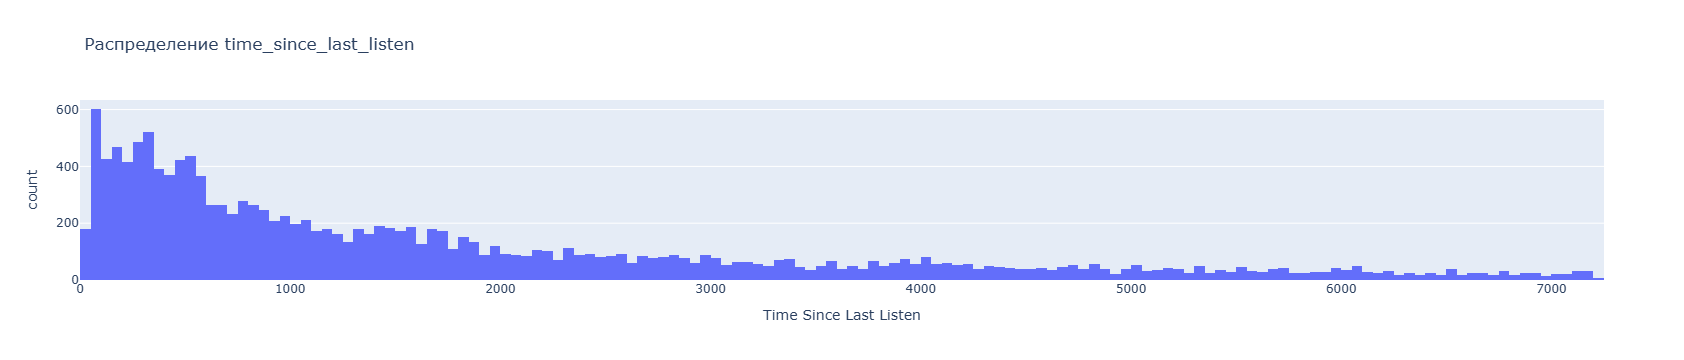

In [76]:
import plotly.express as px

fig = px.histogram(
    tmp,
    x="time_since_last_listen",
    # nbins=1,  # количество корзин, можно увеличить/уменьшить
    title="Распределение time_since_last_listen",
    labels={"time_since_last_listen": "Time Since Last Listen"}
)

fig.show()

In [10]:
pl.scan_parquet("data/multi_event.parquet").filter(pl.col("uid") == 82100).filter(pl.col("item_id")== 1397105).collect()  #28556


uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
u32,u32,u32,u8,u16,u32,enum
82100,25899855,1397105,1,100,190,"""listen"""
82100,25908880,1397105,1,100,190,"""listen"""
82100,25917700,1397105,0,100,190,"""listen"""
